In [1]:
import numpy as np
import matplotlib.pyplot as plt
#from IPython.core.display import HTML
#css_file = './custom.css'
#HTML(open(css_file, "r").read())

Here we try to solve a Rasbha Spin Orbit Coupling without rotation

  
    
    
    
    
    

In [2]:
from GPE import GPE_scalar_field
from GPE import ImEx


In [3]:
#3-d Fiducial example

# Higueras (17)
#A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
#Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
#b = np.array([24/55.,1./5,4./11])
#bhat = b


#
ex_A = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],[0.5,0.0,0.0,0.0,0.0,0.0],[0.25,0.25,0.0,0.0,0.0,0.0],[0.0,-1.0,2.0,0.0,0.0,0.0],[1.0/6.0,0.0,2.0/3.0,1.0/6.0,0.0,0.0],[1.0/6.0,0.0,2.0/3.0,1.0/6.0,0.0,0.0]])
im_A = np.array([[0.0,0.0,0.0,0.0,0.0,0.0],[0.0,0.5,0.0,0.0,0.0,0.0],[0.25,-0.25,0.5,0.0,0.0,0.0],[0.0,1.0,0.0,0.0,0.0,0.0],[1.0/6.0,0.0,2.0/3.0,-4.0/3.0,1.5,0.0],[1.0/6.0,0.0,2.0/3.0,1.0/6.0,-2.0,2.0]])
ex_b = np.array([1.0/6.0,0.0,2.0/3.0,1.0/6.0,0.0,0.0])
im_b = np.array([1.0/6.0,0.0,2.0/3.0,1.0/6.0,-2.0,2.0])


imx = ImEx(6,im_A,ex_A,im_b,ex_b)
gmma1 = np.array([1.1,0.9])
gmma2 = np.array([1.1,0.9])
gmma = np.array([gmma1,gmma2])
kppa = 2.0
bta1 = np.array([400.0,800.0])
bta2 = np.array([800.0,400.0])
bta = np.array([bta1,bta2])


print("gamma beta shape",gmma.shape,bta.shape,gmma,bta)

def V(j,x,y,gmma):

    j=j-1
    return(0.5*(gmma[j,0]*x*x+gmma[j,1]*y*y))


def f(j,psi_1,psi_2,bta):

    j=j-1
    psi_1 = np.square(np.abs(psi_1))
    
    psi_2 = np.square(np.abs(psi_2))
    
    fv = bta[j][0]*psi_1+bta[j][1]*psi_2
    
    return(fv)


def R(j,xix,xiy,psi_other):

    psi_oft = np.fft.fftn(psi_other,psi_other.shape)
    
    psi_oft = 1j*psi_oft*(1j*xix+xiy*np.power(-1.0,3.0-j)) 
    
    psi_oR = 1j*kppa*np.fft.ifftn(psi_oft,psi_oft.shape)
    
    return(psi_oR)
    
    



def rhs_f(u,u_oth,j,x,y,xix,xiy,bta,gmma):
    Vv = V(j,x,y,gmma)
    
    if(j==1):
        fv = f(j,u,u_oth,bta)
    else:
        fv = f(j,u_oth,u,bta)
        
    Rv = R(j,xix,xiy,u_oth)
    
    return(-1j*(Vv+fv)*u + Rv)
    


def im_rhs(psi_ft,u_oth,j,x,y,xix,xiy,bta,gmma):
    
    xi2 = xix*xix+xiy*xiy
   
    psi_ft = -psi_ft*(xi2)
    return(1j*0.5*np.fft.ifftn(psi_ft,psi_ft.shape))



def calc_max_eig(u,xi2,kppa,bta):
    
    u2 = np.square(np.abs(u))
    
    vrhsft = -np.fft.fftn(u2-0.5,u2.shape)/xi2
    vrhsft[0,0,0] = 0.0+0.0*1j
    v = 0.5*(np.fft.ifftn(vrhsft,vrhsft.shape))/kppa;
    
    rhs = np.max(np.abs(bta-v))
    
    
    
    return (rhs)

def sol_err(psi,t,nx,T,max_err=-1.0):

    sol = np.exp(-1j*(2.0*t*np.pi/T))*np.sin(2.0*np.pi*nx)
    #print("sol shape",sol.shape,"psi.shape",psi.shape)
    err = np.square(np.abs(sol-psi).flatten()).sum()
    err = err/(np.square(np.abs(sol).flatten()).sum())
    if(err>max_err):
        max_err = err
    return(max_err)


def solve_rsoc_wor_example(m,dt):
    L = 20.0
    
    x = np.arange(-m/2,m/2)*(L/m)
    xx,yy = np.meshgrid(x,x)
    xi = np.fft.fftfreq(m)*m*2*np.pi/L
    xix,xiy = np.meshgrid(xi,xi)
    
    #nx = np.dot(pnv,xv)
    
    
    T = 2.0
    
    
    p1i = np.genfromtxt("test_phi1_i_ini.txt")
    p1r = np.genfromtxt("test_phi1_r_ini.txt")
    u1_ini = p1r+1j*p1i

    p2i = np.genfromtxt("test_phi2_i_ini.txt")
    p2r = np.genfromtxt("test_phi2_r_ini.txt")
    u2_ini = p2r+1j*p2i
    
    print("u_ini shapes",u1_ini.shape,u2_ini.shape)
    print("xx shapes",xx.shape,yy.shape,xix.shape,xiy.shape)
    
   
    tmax = T

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)

    frames1 = [u1_ini]
    frames2 = [u2_ini]
    tt = [0]
    err_l = []
    mass_l = []
    mass_err_l=[]
    
    
    
    
    psi_1 = GPE_scalar_field(2,m,im_rhs,rhs_f,imx,u1_ini)
    psi_2 = GPE_scalar_field(2,m,im_rhs,rhs_f,imx,u2_ini)
    
    mass_ini = psi_1.mass_ini+psi_2.mass_ini
    
    print("Mass ini is ",mass_ini)
    
    xi2 = (xix*xix+xiy*xiy)
    lmbda = 0.5*(xi2)
    

    
    max_err = -1.0
    
        
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            psi_1.update_stage_sum(k,dt)
            psi_2.update_stage_sum(k,dt)
            psi_1.do_fft(k,lmbda,dt)
            psi_2.do_fft(k,lmbda,dt)
            psi_1.update_K(k,psi_2.f,1,xx,yy,xix,xiy,bta,gmma)
            psi_2.update_K(k,psi_1.f,2,xx,yy,xix,xiy,bta,gmma)
            
            
            
        psi_1.sum_contributions(dt)
        psi_2.sum_contributions(dt)
        
        
        t = (n+1)*dt
        
#        max_egn = calc_max_eig(u,xi2,kppa,bta)
#        if((max_egn*dt)>imx.r_of_stb.imag):
#            print("maxeg*dt",max_egn*dt,imx.r_of_stb.imag)
#            dt  = 0.9*(imx.r_of_stb.imag/max_egn)
        
        
        
        if np.mod(n,nplt) == 0:
            frames1.append(psi_1.psi)
            frames2.append(psi_2.psi)
            tt.append(t)
            
            #err = sol_err(psi.psi,t,nx,T,max_err)
           # err_l.append(err)
            
            mass = psi_1.calc_mass()+psi_2.calc_mass()
            mass_err = (mass-mass_ini)/mass_ini
            
            mass_l.append(mass)
            mass_err_l.append(mass_err)
            
            print("time ",t/tmax,mass)
            


    #err =  sol_err(psi.psi,t,nx,T,max_err)
    #err_l.append(err)
            
    mass = psi_1.calc_mass()+psi_2.calc_mass()
    mass_err = (mass-mass_ini)/mass_ini
            
    mass_l.append(mass)
    mass_err_l.append(mass_err)
       
    return frames1,frames2, mass_l,mass_err_l

gamma beta shape (2, 2) (2, 2) [[1.1 0.9]
 [1.1 0.9]] [[400. 800.]
 [800. 400.]]


In [7]:

dt = 0.001


frames1,frames2, mass_l,mass_err_l = solve_rsoc_wor_example(512,dt)

u_ini shapes (512, 512) (512, 512)
xx shapes (512, 512) (512, 512) (512, 512) (512, 512)
class shapes (512, 512) (6, 512, 512)
(512, 512) (512, 512)
class shapes (512, 512) (6, 512, 512)
(512, 512) (512, 512)
Mass ini is  652.8025000000002
time  0.0005 [652.8025]
time  0.0205 [652.80249981]
time  0.0405 [652.80249968]
time  0.0605 [652.8024995]
time  0.0805 [652.80249931]
time  0.1005 [652.80249919]
time  0.1205 [652.802499]
time  0.1405 [652.80249883]
time  0.1605 [652.80249861]
time  0.1805 [652.80249838]
time  0.2005 [652.80249814]
time  0.2205 [652.80249792]
time  0.2405 [652.80249767]
time  0.2605 [652.80249742]
time  0.2805 [652.80249717]
time  0.3005 [652.80249693]
time  0.3205 [652.80249669]
time  0.3405 [652.80249647]
time  0.3605 [652.80249623]
time  0.3805 [652.80249597]
time  0.4005 [652.80249573]
time  0.4205 [652.80249548]
time  0.4405 [652.80249523]
time  0.4605 [652.80249498]
time  0.4805 [652.80249472]
time  0.5005000000000001 [652.80249446]
time  0.5205 [652.80249423]

In [13]:
f12 = np.square(np.abs(frames1[24]))
f22 = np.square(np.abs(frames2[24]))

b = f12+f22

f12i = np.square(np.abs(frames1[0]))
f22i = np.square(np.abs(frames2[0]))
a = f12i+f22i

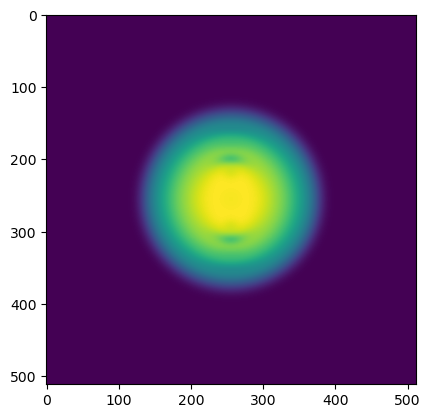

In [16]:
plt.imshow(a)

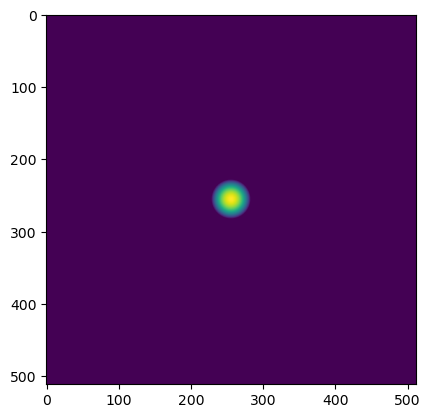

In [16]:
plt.imshow(a)

In [20]:
with open('test_rsoc_data_psi_1.npy', 'rb') as f:
    d = np.load(f)
    print(d.shape)

(51, 512, 512)


In [21]:
with open('test_rsoc_data_psi_1.npy', 'rb') as f:
    d2 = np.load(f)
    print(d2.shape)

(51, 512, 512)


In [8]:
u2_ini.dtype

dtype('complex128')